<a href="https://colab.research.google.com/github/FucsikovaTereza/MMD/blob/main/TASEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space

In [65]:
def plot_grid(tau, rfreq=1, cfreq=1):
    L = len(tau)
    cfreq = np.arange(0.5, L + 1, 1)
    plt.figure(figsize=(L, 1))

    for cf in cfreq:
        plt.plot([cf, cf], [0.5, 1.5], 'k')  # Vertical lines

    particles = np.where(tau == 1)[0]
    plt.plot(particles + 1, np.ones_like(particles), 'ko', markersize=7, markerfacecolor='k')

    plt.xticks(np.arange(1, L + 1))
    plt.yticks([], [])
    plt.xlim(0.5, L + 0.5)
    plt.ylim(0.5, 1.5)
    plt.gca().set_aspect('equal')

    plt.show()


def tasep(p, tau, nmax, gamma):
    L = len(tau)                                        # Length of the ring
    J = np.zeros(L, dtype=float)                        # Flow (average number of particles passed through)
    rho = np.copy(tau).astype(float)                    # Density (average cell occupancy)

    X = np.zeros((nmax, L), dtype=int)                  # State matrix
    n = 0
    while n < nmax:
        can_jump = np.where((tau == 1) & (np.roll(tau, -1) == 0))[0]              # Find particles that can jump
        if len(can_jump) > 0:
            # Leader jumps with base probability p
            leader_jump = can_jump[0]
            if np.random.rand() < p:
                # Other particles may jump with adjusted probability (1 + gamma)p
                adjusted_p = (1 + gamma) * p
                adjusted_p = min(max(adjusted_p, 0), 1)                           # Ensure probability stays within [0, 1]
                for idx in can_jump:
                    if idx == leader_jump or np.random.rand() < adjusted_p:
                        jump_to = (idx + 1) % L
                        tau[idx] = 0                   # Particle leaves current position
                        tau[jump_to] = 1               # Particle arrives at new position
                        J[idx] += 1
        X[n, :] = tau
        rho += tau
        n += 1

    rho /= (nmax + 1)
    J /= nmax
    return X, rho, J


def transitionMatrix(L, N, p):
    # All possible states S
    S = np.array([list(bin(i)[2:].zfill(L)) for i in range(2**L) if bin(i).count('1') == N], dtype=int)

    # Transition matrix P
    n = len(S)
    P = np.zeros((n, n))

    for i in range(n):
        tau = S[i]
        ind_to_jump = np.where((tau == 1) & (np.roll(tau, -1) == 0))[0]     # Indices where particles can jump
        to_jump = len(ind_to_jump)
        # All combinations of possible jumps
        for j in range(2**to_jump):
            option = list(bin(j)[2:].zfill(to_jump))
            option = np.array(option, dtype=int)
            sigma = np.copy(tau)                                            # New state after jumps
            jumps = ind_to_jump[option == 1]
            new_positions = (jumps + 1) % L
            sigma[jumps] = 0
            sigma[new_positions] = 1
            k = np.where((S == sigma).all(axis=1))[0][0]                    # Index of the new state in S
            num_jumps = option.sum()                                        # Probability of this transition
            P[i, k] += p**num_jumps * (1-p)**(to_jump-num_jumps)

    return P, S


def stac(P):
    pi = null_space(P.T - np.eye(P.shape[0]))
    pi = pi[:, 0] / np.sum(pi[:, 0])
    return pi


def distance_histogram(tau, gamma):
    distances = []
    current_distance = 0
    L = len(tau)
    found_first_particle = False

    for i in range(L):
        if tau[i] == 1:
            if found_first_particle:
                distances.append(current_distance)
            else:
                found_first_particle = True
            current_distance = 0
        else:
            current_distance += 1

    # Boundary condition
    if current_distance > 0 and found_first_particle:
        initial_idx = np.argmax(tau == 1)
        if tau[-1] == 1:
            distances.append(current_distance)
        else:
            distances.append(current_distance + initial_idx)

    plt.hist(distances, bins=range(1, max(distances)+2), align='left', rwidth=0.8, label=f'Gamma={gamma}')
    plt.xlabel('Distance between particles')
    plt.ylabel('Frequency')
    plt.title('Distance Histogram')
    plt.legend()
    plt.show()

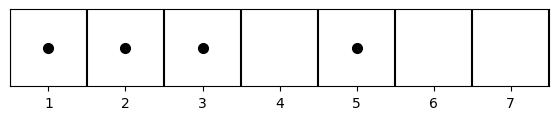

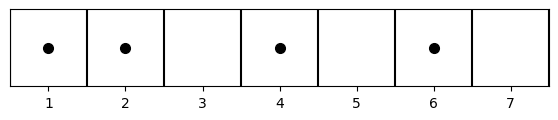

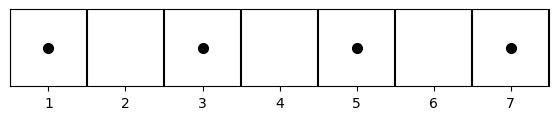

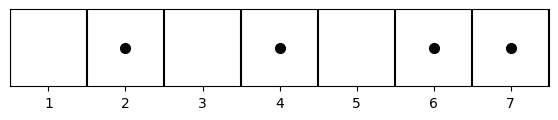

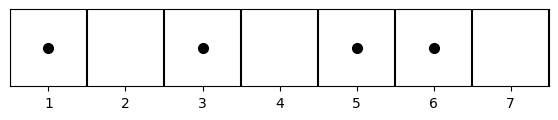

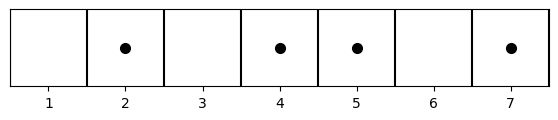

Final State Matrix X:
 [[1 1 0 1 0 1 0]
 [1 0 1 0 1 0 1]
 [0 1 0 1 0 1 1]
 [1 0 1 0 1 1 0]
 [0 1 0 1 1 0 1]]
Average Density rho:
 [0.66666667 0.66666667 0.5        0.5        0.66666667 0.5
 0.5       ]
Flow I:
 [0.4 0.4 0.6 0.4 0.4 0.4 0.2]


In [67]:
# Example of visualisation
p = 1
gamma = 0.5

nmax = 5                                # Maximum number of steps
tau = np.array([1, 1, 1, 0, 1, 0, 0])   # Initial configuration
plot_grid(tau)

X, rho, J = tasep(p, tau, nmax, gamma)
print("Final State Matrix X:\n", X)
print("Average Density rho:\n", rho)
print("Flow I:\n", J)

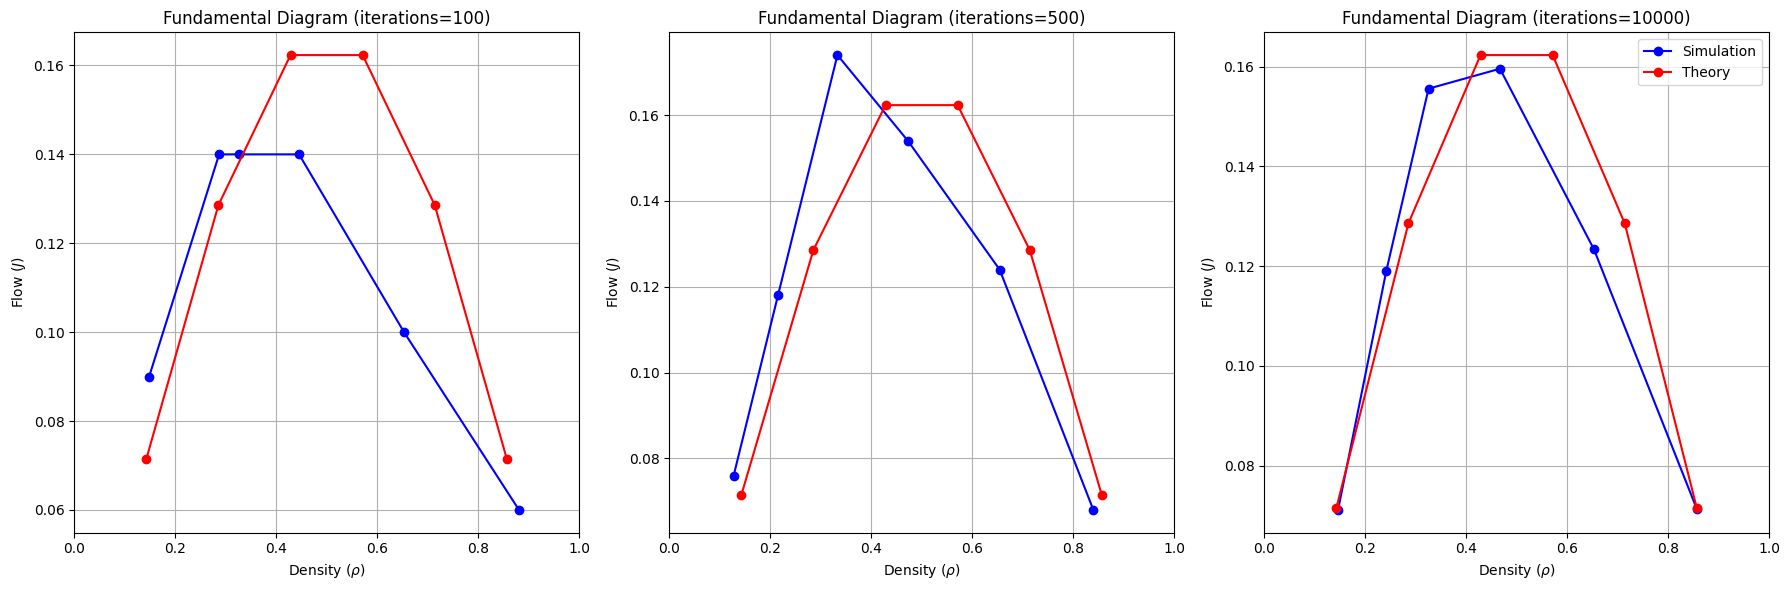

In [53]:
# Fundamental Diagrams for comparison with Theoretical solution (smaller values needed)
L = 7
N = range(1, L)
p = 0.5
gamma = 0.5

nmax_values = [100, 500, 10000]       # nmax values for different simulations

plt.figure(figsize=(18, 6))

for idx, nmax in enumerate(nmax_values):
    rhoS_FD = np.zeros(len(N))
    JS_FD = np.zeros(len(N))
    rhoT_FD = np.zeros(len(N))
    JT_FD = np.zeros(len(N))

    # Run simulations for different numbers of particles
    for i, M in enumerate(N):
        tau = np.zeros(L)
        tau[:M] = 1
        _, rho, J = tasep(p, tau, nmax, gamma)
        rhoS_FD[i] = rho[0] if isinstance(rho, np.ndarray) else rho
        JS_FD[i] = J[0] if isinstance(J, np.ndarray) else J

        # Computation of theoretical values using transitionMatrix and stac
        P, S = transitionMatrix(L, M, p)
        pi = stac(P)
        rhoT_FD[i] = np.dot(pi, S[:, 0])
        JT_FD[i] = p * np.sum(pi * (S[:, 0] & ~np.roll(S, -1, axis=1)[:, 0]))

    ax = plt.subplot(1, 3, idx + 1)
    ax.plot(rhoS_FD, JS_FD, 'b-o', label ='Simulation')
    ax.plot(rhoT_FD, JT_FD, 'r-o', label ='Theory')
    ax.set_title(f'Fundamental Diagram (iterations={nmax})')
    ax.set_xlabel('Density ($\\rho$)')
    ax.set_ylabel('Flow ($J$)')
    ax.set_xlim([0, 1])
    ax.grid(True)

plt.tight_layout()
plt.legend()
plt.show()

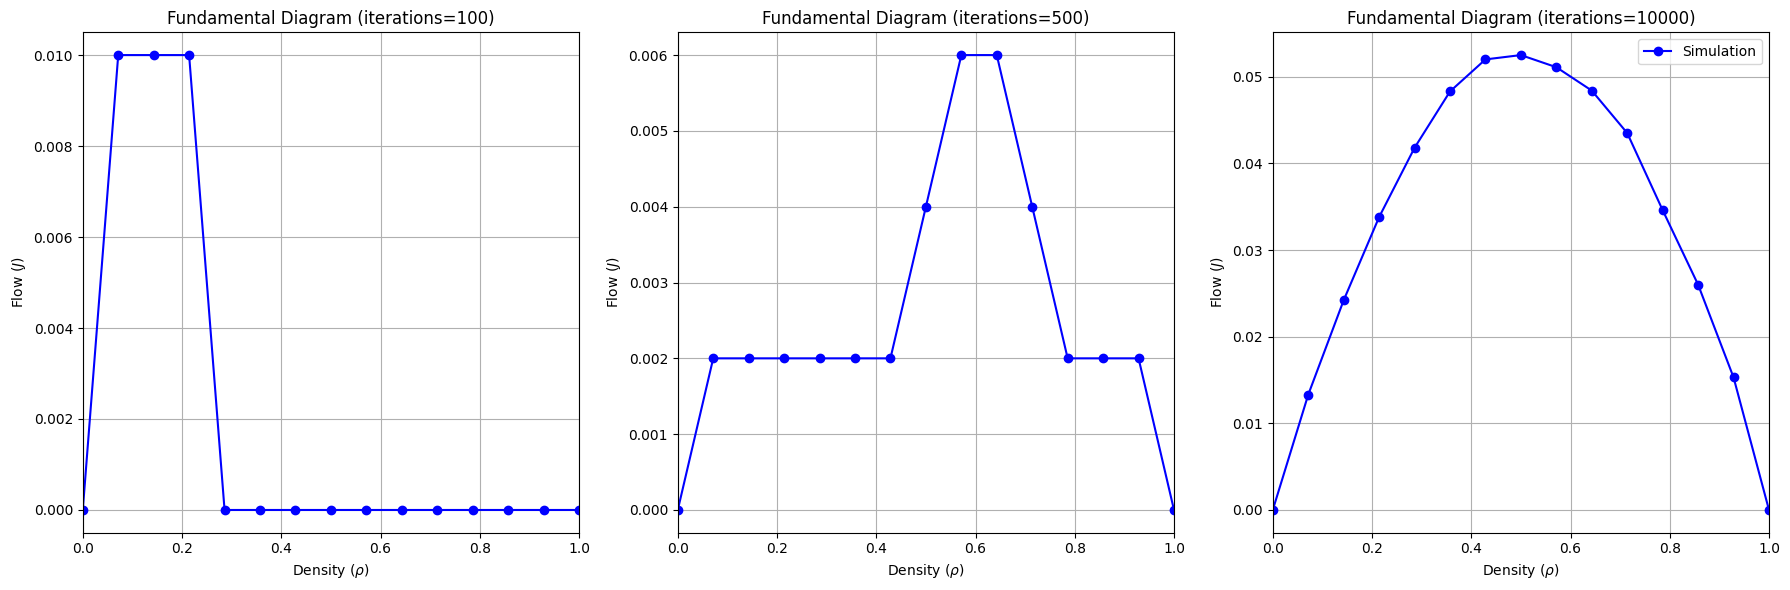

In [56]:
# Fundamental Diagram Simulation for bigger values
L = 200
N = 50
p = 0.5
gamma = -0.2
rho_range = np.linspace(0, 1, 15)

# nmax values for different simulations
nmax_values = [100, 500, 10000]

plt.figure(figsize=(18, 6))

for idx, nmax in enumerate(nmax_values):
    JS_FD = np.zeros(len(rho_range))
    JT_FD = np.zeros(len(rho_range))

    for i, density in enumerate(rho_range):
        N_density = int(L * density)
        tau = np.zeros(L)
        tau[:N_density] = 1
        _, rho, J = tasep(p, tau, nmax, gamma)
        JS_FD[i] = J[0] if isinstance(J, np.ndarray) else J


    ax = plt.subplot(1, 3, idx + 1)
    ax.plot(rho_range, JS_FD, 'b-o', label='Simulation')
    ax.set_title(f'Fundamental Diagram (iterations={nmax})')
    ax.set_xlabel('Density ($\\rho$)')
    ax.set_ylabel('Flow ($J$)')
    ax.set_xlim([0, 1])
    ax.grid(True)

plt.tight_layout()
plt.legend()
plt.show()

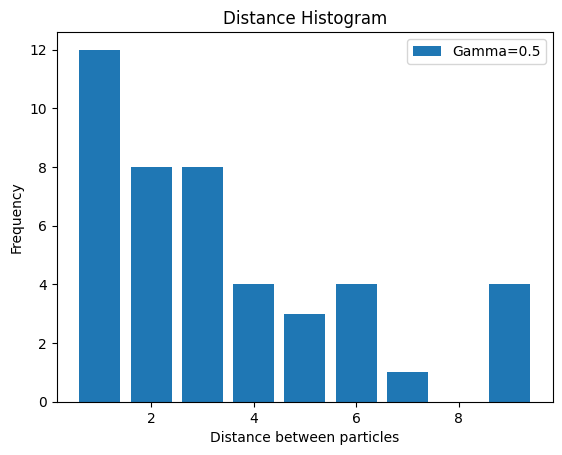

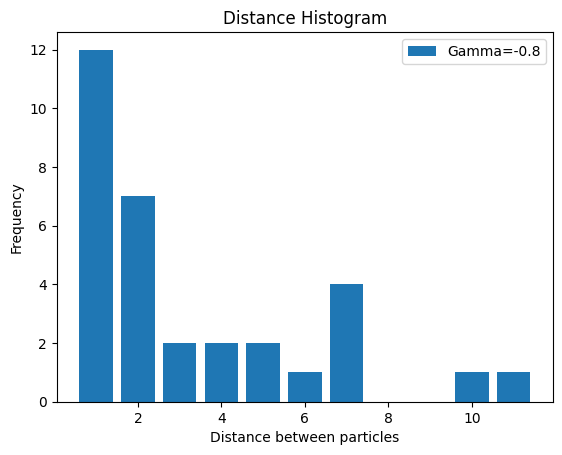

In [51]:
L = 200
N = 50
p = 0.5
nmax = 1000
tau = np.zeros(L)
tau[:N] = 1

for gam in [0.5, -0.8]:
  X, rho, J = tasep(p, tau, nmax, gam)
  distance_histogram(X[-1], gam)